# ECHO STATE NEURAL NETWORK

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Masking,Embedding,Bidirectional,TimeDistributed
from mypyESN import ESN
#%tensorflow_version 2.x

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:

df1=pd.read_csv('../data/anno1/eplusout/eplusout.csv')
df2=pd.read_csv('../data/anno2/eplusout/eplusout.csv')
df3=pd.read_csv('../data/anno3/eplusout/eplusout.csv')


In [3]:
def changetime(df,year):
    datetimeform = []
    for i in range(len(df.index)):
        tt = df["Date/Time"][i]
        days, hours = tt.split('  ')
        tt = f'{days.split("/")[1]}/{days.split("/")[0]}/{year}{hours}'
        tt = tt.replace(' ', '')
        if '201724:' or '201824:' or '201924:' in tt:
            tt=tt.replace('24:', '00:')
            timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
            timestamp += 86400
            #timestamp = datetime.fromtimestamp(timestamp)

        else:
            timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
            #timestamp = datetime.fromtimestamp(timestamp)
        datetimeform.append(timestamp)

    df["TimeStep"]=datetimeform
    
changetime(df1,"2017")
changetime(df2,"2018")
changetime(df3,"2019")
df1.head()

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](TimeStep),...,DistrictCooling:Facility [J](TimeStep),DistrictHeating:Facility [J](TimeStep),Carbon Equivalent:Facility [kg](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),TimeStep
0,04/01 00:10:00,15.433333,NaN,10.3,NaN,101250.666667,NaN,3.0,NaN,19.166667,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491085e+09
1,04/01 00:20:00,14.366667,NaN,10.0,NaN,101280.333333,NaN,2.9,NaN,8.333333,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491085e+09
2,04/01 00:30:00,13.300000,NaN,9.7,NaN,101310.000000,NaN,2.8,NaN,357.500000,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491086e+09
3,04/01 00:40:00,12.233333,NaN,9.4,NaN,101339.666667,NaN,2.7,NaN,346.666667,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491086e+09
4,04/01 00:50:00,11.166667,NaN,9.1,NaN,101369.333333,NaN,2.6,NaN,335.833333,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491087e+09


In [4]:
# selecting only the values to train the rnn on 
x = pd.DataFrame()
meas = ["TimeStep",
        'Electricity:Facility [J](TimeStep)',
        'DistrictCooling:Facility [J](TimeStep)',
        "Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",
        "Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)",
        "Environment:Site Wind Speed [m/s](TimeStep)",
        "Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep)",
        "Environment:Site Wind Direction [deg](TimeStep)",
        "BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON)",
        "BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON)",
        "BLOCK1:KITCHEN:Zone Mean Air Temperature [C](TimeStep:ON)",
        "Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)"]
for m in meas:
    x[m]=pd.concat([df1[m],df2[m],df3[m]])
x.reset_index(inplace=True,drop=True)

In [5]:
x.head()

,TimeStep,Electricity:Facility [J](TimeStep),DistrictCooling:Facility [J](TimeStep),Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Wind Direction [deg](TimeStep),BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON),BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON),BLOCK1:KITCHEN:Zone Mean Air Temperature [C](TimeStep:ON),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)
0,1.491085e+09,27449.355191,0.0,15.433333,0.0,3.0,101250.666667,19.166667,23.680708,24.583088,25.289039,0.0
1,1.491085e+09,27449.355191,0.0,14.366667,0.0,2.9,101280.333333,8.333333,23.570734,24.486530,25.161093,0.0
2,1.491086e+09,27449.355191,0.0,13.300000,0.0,2.8,101310.000000,357.500000,23.452511,24.386547,25.017417,0.0
3,1.491086e+09,27449.355191,0.0,12.233333,0.0,2.7,101339.666667,346.666667,23.340556,24.291091,24.875268,0.0
4,1.491087e+09,27449.355191,0.0,11.166667,0.0,2.6,101369.333333,335.833333,23.232600,24.196600,24.736677,0.0


In [6]:
x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TimeStep,79056.0,1.530525e+09,2.615061e+07,1.491084e+09,1.502942e+09,1.530525e+09,1.558108e+09,1.569967e+09
Electricity:Facility [J](TimeStep),79056.0,1.306167e+05,1.593147e+05,2.744936e+04,2.744936e+04,2.744936e+04,3.394476e+05,5.384741e+05
DistrictCooling:Facility [J](TimeStep),79056.0,6.310116e+05,4.708801e+05,0.000000e+00,1.929206e+05,5.549145e+05,1.050636e+06,1.905375e+06
Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),79056.0,2.435966e+01,5.218590e+00,6.200000e+00,2.109583e+01,2.480000e+01,2.830000e+01,3.800000e+01
Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),79056.0,2.837174e+02,3.359258e+02,0.000000e+00,0.000000e+00,4.700000e+01,6.553333e+02,9.190000e+02
Environment:Site Wind Speed [m/s](TimeStep),79056.0,3.948260e+00,2.656548e+00,0.000000e+00,1.900000e+00,3.350000e+00,5.600000e+00,1.650000e+01
Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),79056.0,1.010223e+05,3.484209e+02,9.968200e+04,1.007928e+05,1.011000e+05,1.012970e+05,1.022000e+05
Environment:Site Wind Direction [deg](TimeStep),79056.0,2.097937e+02,8.884432e+01,0.000000e+00,1.716667e+02,2.166667e+02,2.800000e+02,3.598333e+02
BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON),79056.0,2.530400e+01,9.571113e-01,2.120076e+01,2.437314e+01,2.600000e+01,2.600000e+01,2.799143e+01
BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON),79056.0,2.584607e+01,4.615881e-01,2.203593e+01,2.600000e+01,2.600000e+01,2.600000e+01,2.600000e+01


In [7]:
num_features = x.shape[1]
print("The number of features is: ",num_features)

The number of features is:  12


In [8]:
ntot = len(x)

#first two years for trainig 

x_train = x[:(len(df1)+len(df2))]
#x_train.set_index("TimeStep",inplace=True)
mean = x_train.mean()
std = x_train.std()
x_train_norm = (x_train - mean)/std
print("Training set dimension: ",len(x_train))

# Split last year in validation and test

x_val =  x[(len(df1)+len(df2)): (len(df1)+len(df2)) + int(0.5*len(df3)) ]
#x_val.set_index("TimeStep",inplace=True)
x_val_norm = (x_val-mean)/std
print("Validation set dimension: ",len(x_val))

x_test =  x[(len(df1)+len(df2)) + int(0.5*len(df3)):]
#x_test.set_index("TimeStep",inplace=True)
x_test_norm = (x_test-mean)/std
print("Test set dimension: ",len(x_test))

Training set dimension:  52704
Validation set dimension:  13176
Test set dimension:  13176


In [24]:
std["DistrictCooling:Facility [J](TimeStep)"]

470479.0880772319

In [22]:
type(mean)

pandas.core.series.Series

powr2 = x.diff().copy()
#powr2=powr[0:1000]
#powr2.set_index("TimeStep",inplace=True)
powr2.reset_index(inplace=True)
powr2['DistrictCooling:Facility [J](TimeStep)'].plot(figsize=(20,20))

In [52]:
n_reservoir= 500
sparsity=0.2
rand_seed=23
spectral_radius = 1.2
noise = .0005

esn = ESN(n_inputs = 1,
      n_outputs= 1,
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise,
      input_shift=mean["DistrictCooling:Facility [J](TimeStep)"],
      input_scaling=std["DistrictCooling:Facility [J](TimeStep)"],
      teacher_shift=mean["DistrictCooling:Facility [J](TimeStep)"],
      teacher_scaling=std["DistrictCooling:Facility [J](TimeStep)"],
      silent=True)

trainlen = len(x_train)
future = 6
futureTotal=len(x_val)
pred_tot=np.zeros(futureTotal)
dropTimesteps = x.copy()["DistrictCooling:Facility [J](TimeStep)"].to_numpy()

for i in range(0,1):
    if i%10 == 0:
        print("Round ",i)
    #test = np.ones(trainlen)
    test=dropTimesteps[:trainlen]
    pred_training = esn.fit(test.drop("DistrictCooling:Facility [J](TimeStep)",1),dropTimesteps[i:trainlen+i]["DistrictCooling:Facility [J](TimeStep)"])
    prediction = esn.predict(np.ones(future))
    pred_tot[i:i+future] = prediction[:,0]
print("Done")

Running for  2196.0 times
Round  0
Done


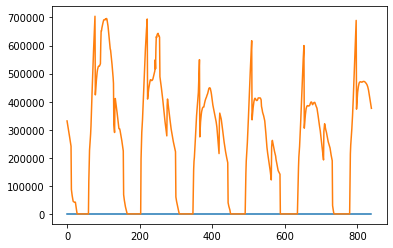

In [53]:
plt.plot(pred_tot[3000:3840])
plt.plot(dropTimesteps[3000:3840])

In [ ]:
import seaborn as sns

plt.figure(figsize=(16,8))
#plt.plot(range(0,trainlen+futureTotal),x[0:trainlen+futureTotal],'b',label="Data", alpha=0.3)
#plt.plot(range(0,trainlen),pred_training,'.g',  alpha=0.3)
plt.plot(range(trainlen,trainlen+futureTotal//100),pred_tot[:131],'k',  alpha=0.8, label='Free Running ESN')
